In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import graphviz
from scipy.interpolate import lagrange
from scipy import interpolate
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error

(1) A Simplified Decision Tree

In [168]:
class Node(): #define structure of each node
    def __init__(self, feature_index=None, threshold=None, left=None, 
                 right=None, gain_ratio=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain_ratio = gain_ratio
        self.value = value
        
class DTClassifier(): #define the classification tree
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None #root node
        self.min_samples_split = min_samples_split #termination criteria 1
        self.max_depth = max_depth #termination criteria 2
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["gain_ratio"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"]
                                               , curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"]
                                                , curr_depth+1)
                
                return Node(best_split["feature_index"], best_split["threshold"], 
                           left_subtree, right_subtree, best_split["gain_ratio"])
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
     
    def infogain_ratio(self, parent, l_child, r_child): #splitting criterion
        weight_l = len(l_child)/len(parent)
        weight_r = len(r_child)/len(parent)
        info_gain = self.entropy(parent) - (weight_l*self.entropy(l_child) 
                                  + weight_r*self.entropy(r_child)) #numerator
        intri_info = -(weight_l*np.log2(weight_l)+weight_r*np.log2(weight_r)) 
                                                                #denominator
        gain_ratio = info_gain/intri_info

        return gain_ratio
    
    def entropy(self,y): #impurity measure
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y==cls])/len(y)
            entropy = -p_cls*np.log2(p_cls)
        return entropy
    
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]
                                 <=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]
                                  >threshold])
        return dataset_left, dataset_right
    
    def get_best_split(self, dataset, num_samples, num_features): 
                        #to return dictionary of details of best split at a node
        best_split = {}
        max_gain_ratio = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, 
                                                      feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:  
                                                          #Null set redundancy
                    y, left_y, right_y = dataset[:,-1], 
                                      dataset_left[:,-1], dataset_right[:,-1]
                    curr_gain_ratio = self.infogain_ratio(y, left_y, right_y) 
                    if curr_gain_ratio>max_gain_ratio:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["gain_ratio"] = curr_gain_ratio
                        max_gain_ratio = curr_gain_ratio
        return best_split
        
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root
        
        if tree.value is not None:
            print(tree.value)
        
        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, 
                                          "Gain_Ratio:", tree.gain_ratio)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent+indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent+indent)
            
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis = 1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions



    #Auxiliary functions

    #alternative impurity measure
    def gini_index(self,y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y==cls])/len(y)
            gini += p_cls**2
        return (1-gini)

    #tree visualization using graphviz
    def to_graphviz(self, node=None, dot=None):
        if dot is None:
            dot = graphviz.Digraph()
            dot.attr('node', shape='box')

        if node is None:
            node = self.root

        if node.value is not None:
            dot.node(str(node), label=str(node.value), shape='oval')
        else:
            dot.node(str(node),
                     label="X_{} <= {}\nGain Ratio: {}".format(node.feature_index,
                                                        node.threshold,
                                                        node.gain_ratio))
            if node.left:
                dot.edge(str(node), str(node.left), label='Yes')
                self.to_graphviz(node.left, dot=dot)
            if node.right:
                dot.edge(str(node), str(node.right), label='No')
                self.to_graphviz(node.right, dot=dot)

        return dot

    #get_all_splits - altered version of get_best_split
    def get_all_splits(self, dataset, num_samples, num_features): 
      all_splits = []
      for feature_index in range(num_features):
        feature_values = dataset[:, feature_index]
        possible_thresholds = np.unique(feature_values)
        for threshold in possible_thresholds:
            dataset_left, dataset_right = self.split(dataset,
                                                     feature_index, threshold)
            if len(dataset_left)>0 and len(dataset_right)>0:#Null set redundancy
                y, left_y, right_y = dataset[:,-1], 
                dataset_left[:,-1], dataset_right[:,-1]
                curr_gain_ratio = self.infogain_ratio(y, left_y, right_y)
                split = {}
                split["feature_index"] = feature_index
                split["threshold"] = threshold
                split["dataset_left"] = dataset_left
                split["dataset_right"] = dataset_right
                split["gain_ratio"] = curr_gain_ratio
                all_splits.append(split)
      return all_splits

        

(2) Questions

2.Our Algorithm is Greedy

In [126]:
#Greedy algorithms does not split on node since gain ratio is zero for all splits
#consider a training set (y = x0 XOR x1)
dgreedy = pd.DataFrame({"x0":[0,0,1,1], "x1":[0,1,0,1], "y":[0,1,1,0]})
dgreedy.head()

Xdg = dgreedy.iloc[:, :-1].values
Ydg = dgreedy.iloc[:, -1].values.reshape(-1,1)
#Xdg_train, Xdg_test, Ydg_train, Ydg_test = train_test_split(Xdg, Ydg, test_size = 0.2, random_state = 41)

clasdg = DTClassifier(max_depth=3)
clasdg.fit(Xdg, Ydg)
clasdg.print_tree()
clasdg.get_all_splits(dgreedy.values, 
                      num_samples=dgreedy.shape[0], 
                      num_features=dgreedy.shape[1]-1)

0


[{'feature_index': 0, 'threshold': 0, 'dataset_left': array([[0, 0, 0],
         [0, 1, 1]]), 'dataset_right': array([[1, 0, 1],
         [1, 1, 0]]), ' gain_ratio': 0.0},
 {'feature_index': 1, 'threshold': 0, 'dataset_left': array([[0, 0, 0],
         [1, 0, 1]]), 'dataset_right': array([[0, 1, 1],
         [1, 1, 0]]), ' gain_ratio': 0.0}]

Text(0, 0.5, 'x1')

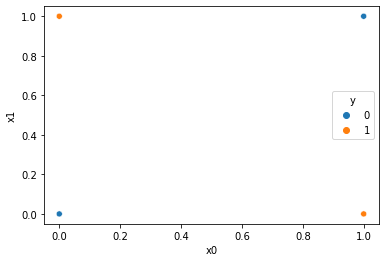

In [127]:
sns.scatterplot(data = dgreedy, x = "x0", y = "x1", hue = "y")
plt.xlabel("x0")
plt.ylabel("x1")
#plt.savefig("/content/drive/MyDrive/CS760/data/dgreedy_simple.pdf")

3.Information Gain Ratio exercise (using Druns.txt)

In [171]:
Druns = pd.read_csv("/content/drive/MyDrive/CS760/data/Druns.txt", 
                    header=None, delimiter=" ")
Xdr = Druns.iloc[:, :-1].values
Ydr = Druns.iloc[:, -1].values.reshape(-1,1)

clasdr = DTClassifier(min_samples_split=3, max_depth=3)
clasdr.fit(Xdr, Ydr)
clasdr.print_tree()
dotdr = clasdr.to_graphviz()
dotdr.render("/content/drive/MyDrive/CS760/data/treedr", 
             format="pdf", view=True)

X_1 <= 7.0 Gain_Ratio: 0.20261823963697306
 left:X_1 <= -1.0 Gain_Ratio: 0.08918563972429702
  left:0.0
  right:X_1 <= 5.0 Gain_Ratio: 0.30815572670182784
    left:0.0
    right:1.0
 right:1.0


'/content/drive/MyDrive/CS760/data/treedr.pdf'

In [183]:
#all possible splits
dr_allsplits = clasdr.get_all_splits(Druns.values, num_samples=Druns.shape[0], 
                                     num_features=Druns.shape[1]-1)
all_splits_dr = {}
for i in range(len(dr_allsplits)):
  all_splits_dr[dr_allsplits[i]["threshold"]]=dr_allsplits[i]["gain_ratio"]
all_splits_dr

{0.0: 0.004134361822329767,
 -2.0: 0.08532700368525298,
 -1.0: 0.03768493061875353,
 1.0: 0.0008361170391545524,
 2.0: 0.012031302277411976,
 3.0: 0.036087129188984095,
 4.0: 0.0784495070145669,
 5.0: 0.15630758017314603,
 6.0: 0.03768493061875353,
 7.0: 0.20261823963697306}

4.The King of Interpretability (using D3leaves.txt)

In [188]:
d3l = pd.read_csv("/content/drive/MyDrive/CS760/data/D3leaves.txt", 
                  header=None, delimiter=" ")
#print(d3l)
Xd3l = d3l.iloc[:, :-1].values
Yd3l = d3l.iloc[:, -1].values.reshape(-1,1)

clasd3l = DTClassifier(min_samples_split=3, max_depth=3)
clasd3l.fit(Xd3l, Yd3l)
clasd3l.print_tree()
dotd3l = clasd3l.to_graphviz()
dotd3l.render("/content/drive/MyDrive/CS760/data/treed3l", 
              format="pdf", view=True)
#.get_all_splits(d3l.values, num_samples=d3l.shape[0], num_features=d3l.shape[1]-1)

X_0 <= 1 Gain_Ratio: 0.0592640616716532
 left:0
 right:1


'/content/drive/MyDrive/CS760/data/treed3l.pdf'

5.Or is it? (using D1.txt and D2.txt)

In [135]:
#D1
D1 = pd.read_csv("/content/drive/MyDrive/CS760/data/D1.txt", 
                 header = None, delimiter = " ")
#print(D1)
XD1 = D1.iloc[:, :-1].values
YD1 = D1.iloc[:, -1].values.reshape(-1,1)

clasD1 = DTClassifier(min_samples_split=3, max_depth=10)
clasD1.fit(XD1, YD1)
clasD1.print_tree()
dotD1 = clasD1.to_graphviz()
dotD1.render("/content/drive/MyDrive/CS760/data/treeD1", 
             format="pdf", view=True)

X_1 <= 0.199725 Gain_Ratio: 0.34224231746621286
 left:0.0
 right:1.0


'/content/drive/MyDrive/CS760/data/treeD1.pdf'

In [189]:
#D2
D2 = pd.read_csv("/content/drive/MyDrive/CS760/data/D2.txt", 
                 header = None, delimiter = " ")
#print(D2)
XD2 = D2.iloc[:, :-1].values
YD2 = D2.iloc[:, -1].values.reshape(-1,1)

clasD2 = DTClassifier(min_samples_split=3, max_depth=10)
clasD2.fit(XD2, YD2)
clasD2.print_tree()
dotD2 = clasD2.to_graphviz()
dotD2.render("/content/drive/MyDrive/CS760/data/treeD2", 
             format="pdf", view=True)

X_0 <= 0.038138 Gain_Ratio: 0.11553657575459955
 left:0.0
 right:X_1 <= 0.0377 Gain_Ratio: 0.1162540631473518
  left:0.0
  right:X_0 <= 0.532664 Gain_Ratio: 0.10740390335826173
    left:X_1 <= 0.689616 Gain_Ratio: 0.29527495478959565
        left:X_1 <= 0.532684 Gain_Ratio: 0.1296178968540568
                left:0.0
                right:X_0 <= 0.409387 Gain_Ratio: 0.5046187441961629
                                left:X_0 <= 0.387288 Gain_Ratio: 0.14389715603063133
                                                                left:0.0
                                                                right:X_0 <= 0.393227 Gain_Ratio: 0.6432574411028116
                                                                                                                                left:1.0
                                                                                                                                right:0.0
                                right:X_0 <= 0.417579 Gain_Rat

'/content/drive/MyDrive/CS760/data/treeD2.pdf'

6.Hypothesis Space

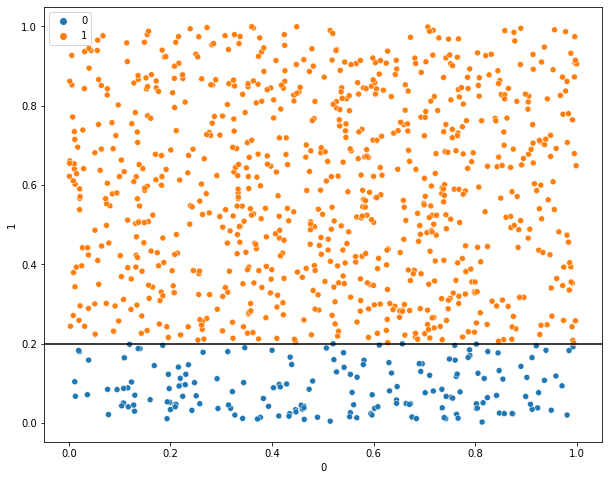

In [190]:
#Scatter Plot D1
plt.figure(figsize = (10,8))
sns.scatterplot(data = D1, x = 0, y = 1, hue = 2)
plt.axhline(y=0.199725, color = 'black')
plt.legend()
plt.savefig("/content/drive/MyDrive/CS760/data/D1.pdf")

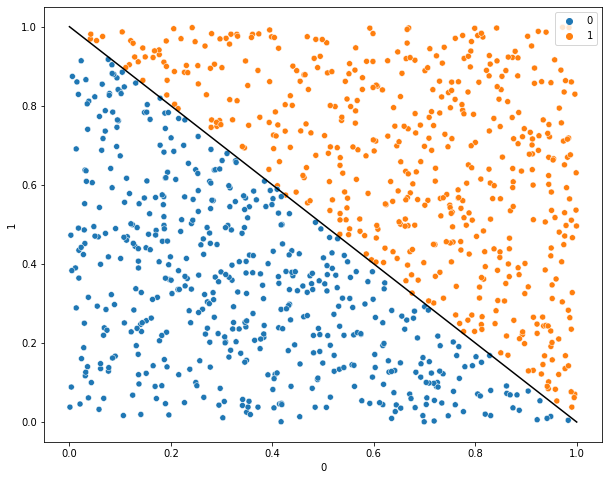

In [191]:
#Scatter Plot D2
plt.figure(figsize = (10,8))
sns.scatterplot(data = D2, x = 0, y = 1, hue = 2)
plt.legend()
plt.plot(np.array([0,1]), np.array([1,0]), color="black")
plt.savefig("/content/drive/MyDrive/CS760/data/D2.pdf")

7.Learning Curve (using Dbig.txt)

In [286]:
Dbig = pd.read_csv("/content/drive/MyDrive/CS760/data/Dbig.txt", header = None, 
                   delimiter = " ")
#Dbig.head()

In [287]:
#create subset datasets
n = [32, 128, 512, 2048, 8192]

D4 = Dbig.sample(frac = 1).reset_index(drop=True)
D8192 = D4[0:8192]
d4test = D4[8193:]
D2048 = D8192.sample(frac = 1).reset_index(drop=True)[0:2048]
D512 = D2048.sample(frac = 1).reset_index(drop=True)[0:512]
D128 = D512.sample(frac = 1).reset_index(drop=True)[0:128]
D32 = D128.sample(frac = 1).reset_index(drop=True)[0:32]
d4train = [D32, D128, D512, D2048, D8192]


In [288]:
def count_nodes(node):
    if node is None:
        return 0
    return 1 + count_nodes(node.left) + count_nodes(node.right)
num_nodes_DTerr = []

In [289]:
#list number of nodes in each tree and visualize decision trees' decision boundaries
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)

    plt.figure(figsize=(10,7))
    plt.contour(xx, yy, Z, colors='k')
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='bwr')
    plt.xlabel("x0")
    plt.ylabel("x1")
    

In [290]:
def DT_err(n_samples, dataset): 
    X_train = dataset.iloc[:, :-1].values
    Y_train = dataset.iloc[:, -1].values.reshape(-1,1)
    X_test = d4test.iloc[:, :-1].values
    Y_test = d4test.iloc[:, -1].values.reshape(-1,1)
    
    dt = DTClassifier(min_samples_split=3, max_depth=10)
    dt.fit(X_train, Y_train)
    #dt.print_tree()
    num_nodes_DTerr.append(count_nodes(dt.root)) #node_count function added to the loop
    
    plot_decision_boundary(dt, X_train, Y_train)
    plt.savefig("/content/drive/MyDrive/CS760/data/"+f'scatterplot_{i}.pdf')
    plt.clf()  # Clear the figure before the next iteration

    
    Y_pred = dt.predict(X_test)
    return (1-accuracy_score(Y_test, Y_pred))
    

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

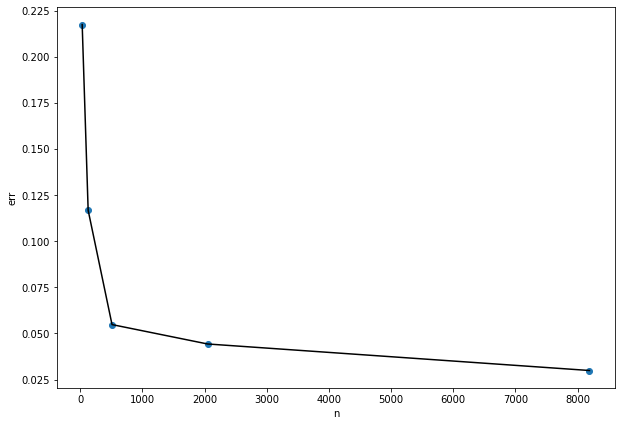

In [291]:
#Learning Curve and the rest of the DT_err function
err = list(range(5))
for i in range(0,5):
    err[i] = DT_err(n[i], d4train[i])
#print(err)
plt.scatter(n,err)
plt.plot(n, err, color="black")
plt.xlabel("n")
plt.ylabel("err")
plt.savefig("/content/drive/MyDrive/CS760/data/LCerr.pdf")

In [292]:
pd.DataFrame({"n":n, "Node Count":num_nodes_DTerr, "err":err})


,n,Node Count,err
0,32,9,0.217488
1,128,25,0.116768
2,512,57,0.054787
3,2048,97,0.044272
4,8192,175,0.029884


(3) sklearn

In [146]:
from sklearn.tree import DecisionTreeClassifier
n_nodes = []
def DT_errsk(n_samples, dataset):
    X_train = dataset.iloc[:, :-1].values
    Y_train = dataset.iloc[:, -1].values.reshape(-1,1)
    X_test = d4test.iloc[:, :-1].values
    Y_test = d4test.iloc[:, -1].values.reshape(-1,1)
    
    dt = DecisionTreeClassifier(criterion='entropy', 
                                min_samples_split=3, 
                                max_depth=10, random_state=41)
    dt.fit(X_train, Y_train)
    #dt.print_tree()
    n_nodes.append(dt.tree_.node_count)
    Y_pred = dt.predict(X_test)
    return (1-accuracy_score(Y_test, Y_pred))

errsk = list(range(5))
for i in range(0,5):
    errsk[i] = DT_errsk(n[i], d4train[i])
errsk

[0.18262313226342008,
 0.12064194798007744,
 0.05368013281682349,
 0.026009961261759806,
 0.022689540675152164]

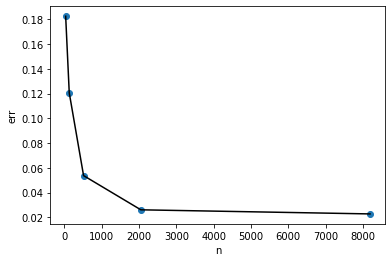

In [147]:
plt.scatter(n, errsk)
plt.plot(n, errsk, color="black")
plt.xlabel("n")
plt.ylabel("err")
plt.savefig("/content/drive/MyDrive/CS760/data/LCerrsk.pdf")

In [148]:
# plt.bar(n, n_nodes, color="red", width=100)
pd.DataFrame({"n":n, "Node Count":n_nodes, "err":errsk})

,n,Node Count,err
0,32,7,0.182623
1,128,17,0.120642
2,512,39,0.053680
3,2048,79,0.026010
4,8192,119,0.022690


(4) Lagrange Interpolation

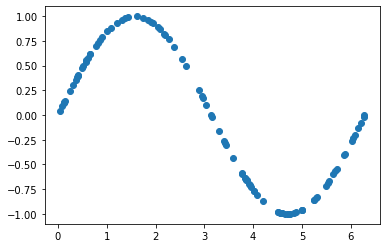

In [349]:
import math
a = 0
b = 2*math.pi
n_test = 16

#training set
np.random.RandomState(seed = 41)
x = np.random.uniform(low=a, high=b, size=100)
#x = sorted(x)
y = [math.sin(i) for i in x]

plt.scatter(x,y)

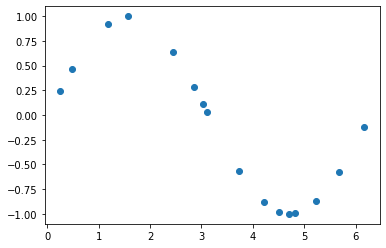

In [350]:
#test set
poly = lagrange(x[0:n_test], y[0:n_test])
x_t = np.random.uniform(low=a, high=b, size=n_test)
f = Polynomial(poly.coef[::-1])(x_t)
plt.scatter(x_t, f)
#Polynomial(poly.coef[::-1])

In [351]:
#error - COMPUTE BOTH TRAIN AND TEST
print("Train err:", mean_squared_error(y[0:n_test],
                                       Polynomial(poly.coef[::-1])(x[0:n_test])))
print("Test err:", mean_squared_error([math.sin(k) for k in x_t], f))

Train err: 9.440821939676908e-06
Test err: 1.4054333676092519e-05


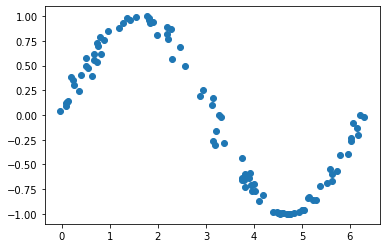

In [352]:
#training set with zero-mean Gaussian noise
np.random.RandomState(seed=41)
ϵ = np.random.normal(0, 0.1, 100)
x1 = x + ϵ
plt.scatter(x1, y)

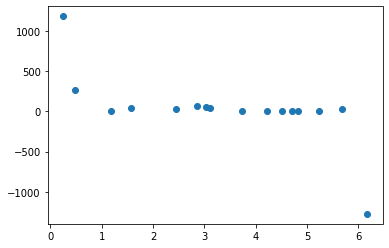

In [353]:
#testing set
poly1 = lagrange(x1[0:n_test], y[0:n_test])
f1 = Polynomial(poly1.coef[::-1])(x_t)
plt.scatter(x_t, f1)

In [354]:
print("Train err:", mean_squared_error(y[0:n_test],
                                       Polynomial(poly1.coef[::-1])(x1[0:n_test])))
print("Test err:", mean_squared_error([math.sin(k) for k in x_t], f1))

Train err: 4.962541057771088e-07
Test err: 193972.15697916385


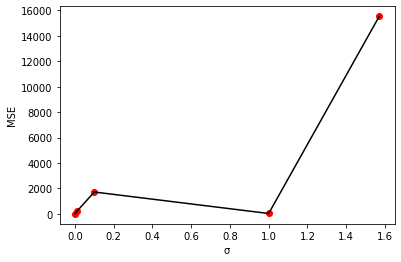

In [355]:
#impact of standard deviation of noise on model performance
nt = [0, 0.01, 0.1, 1, math.pi/2]
mset = []
for i in nt:
  np.random.RandomState(seed=41)
  eps = np.random.normal(0, i, 100)
  xt = x + eps
  pt = lagrange(xt[0:n_test], y[0:n_test])
  ft = Polynomial(pt.coef[::-1])(x_t)
  mset.append(mean_squared_error([math.sin(k) for k in x_t], ft))

plt.scatter(nt, mset, color='red')
plt.plot(nt, mset, color="black")
plt.xlabel("σ")
plt.ylabel("MSE")
plt.savefig("/content/drive/MyDrive/CS760/data/MSEvσ.pdf")